# Classification

## Download of the dataset

In [61]:
datasets = ['ThoracicSurgery_pca_test.csv',
            'ThoracicSurgery_train.csv',
            'ThoracicSurgery_RandomOverSampler_train.csv',
            'ThoracicSurgery_pca_train.csv',
            'ThoracicSurgery_with_outliers_normalized_test.csv',
            'ThoraricSurgery.csv',
            'ThoracicSurgery_Smote_train.csv',
            'ThoracicSurgery_test.csv',
            'ThoracicSurgery_with_outliers_normalized_train.csv'
]

!rm -rf dataset 
!mkdir dataset
!rm -rf trained_models 
!mkdir trained_models
!mkdir images
!mkdir images/confusion_matrix
!mkdir images/roc
!mkdir images/decision_boundaries
!mkdir images/feature_importance
!mkdir tuned_classifiers

for dataset in datasets:
  !wget https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/dataset/{dataset} -P dataset -nc

!wget https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/finetuned_list.txt -P . -nc


mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/confusion_matrix’: File exists
mkdir: cannot create directory ‘images/roc’: File exists
mkdir: cannot create directory ‘images/decision_boundaries’: File exists
mkdir: cannot create directory ‘images/feature_importance’: File exists
mkdir: cannot create directory ‘tuned_classifiers’: File exists
--2021-11-30 16:01:30--  https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/dataset/ThoracicSurgery_pca_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25375 (25K) [text/plain]
Saving to: ‘dataset/ThoracicSurgery_pca_test.csv’

ThoracicSurgery_pca 100%[===================>]  24.78K  --.-KB/s    in 0.001s  

2021-11-30 16:01:31 (19.1 MB/s) - ‘da

**###########################################################**

**De-comment this cell to download the already trained classifiers and save time!**

**###########################################################**


In [ ]:
# models_file = open('finetuned_list.txt', 'r')
# models = models_file.readlines()

# for model in models:
#  print("model: ", model)
#  !pwd
#  !wget -P tuned_classifiers -nc https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/finetuned_models/{model} 

In [63]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree, svm, linear_model, ensemble, neighbors 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from joblib import dump, load

In [64]:
def remove_prefix(df, col, prefix):
    df[col] = df[col].apply(lambda s: int(s.replace(prefix, '')))
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())  
    return df

In [65]:
DATASET_PATH = Path('.') / 'dataset' 

def load_dataset(name):
    path = DATASET_PATH / name
    df = pd.read_csv(path)

    if 'pca' not in str(name):
      remove_prefix(df, 'Diagnosis', 'DGN')
      remove_prefix(df, 'Performance', 'PRZ')
      remove_prefix(df, 'Tumor_Size', 'OC')

    return df

## Classification loop

In [66]:
decision_tree_parameters = {
  'max_depth': list(range(2, 10)),
  'min_samples_split': list(range(2, 10)),
  'criterion' : ['gini', 'entropy'],
  'random_state': [42]
}

SVC_parameters = {
  'C': [0.1, 1, 10, 100],
  'gamma': [1, 0.1, 0.01, 0.001],
  'kernel': ['rbf'] #, 'poly', 'linear']
}

logistic_regression_parameters = {
    'penalty': ['l1', 'l2'],
    'random_state': [42],
    'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
    'max_iter': [1000],
    'solver': ['liblinear']
}

random_forest_parameters = {
    'n_estimators': [10, 100, 1000],
    'criterion' : ['gini', 'entropy'],
    'random_state': [42],
    'max_depth': list(range(2, 8)), #intervallo derivante dal finetuning del decision tree
    'min_samples_split': list(range(2, 9)), #intervallo derivante dal finetuning del decision tree
    'max_features': ['sqrt'],
}

KNN_parameters = {
    'leaf_size' : list(range(1,50, 4)),
    'n_neighbors' : list(range(1,35, 4)), #1+4n is always odd
    'p': [1, 2], #power parameter for the Minkowski metric.
    'weights': ['uniform', 'distance' ],
    'n_jobs' : [-1]
}

classifiers = {
  'DecisionTree': tree.DecisionTreeClassifier(),
  'SVC': svm.SVC(),
  'LogisticRegression': linear_model.LogisticRegression(),
  'RandomForest': ensemble.RandomForestClassifier(),
  'KNN': neighbors.KNeighborsClassifier()
}

classifiers_parameters = {
  'DecisionTree': decision_tree_parameters,
  'SVC': SVC_parameters,
  'LogisticRegression': logistic_regression_parameters,
  'RandomForest': random_forest_parameters,
  'KNN': KNN_parameters
}

train_datasets = {
  'with_outliers': load_dataset(name= 'ThoracicSurgery_with_outliers_normalized_train.csv'),
  'no_oversampling': load_dataset(name='ThoracicSurgery_train.csv'),
  'random_oversampling': load_dataset(name='ThoracicSurgery_RandomOverSampler_train.csv'),
  'SMOTE': load_dataset(name='ThoracicSurgery_Smote_train.csv'),
  'PCA': load_dataset(name='ThoracicSurgery_pca_train.csv')
}

test_datasets = {
  'with_outliers': load_dataset(name= 'ThoracicSurgery_with_outliers_normalized_test.csv'),
  'no_oversampling': load_dataset(name='ThoracicSurgery_test.csv'),
  'random_oversampling': load_dataset(name='ThoracicSurgery_test.csv'),
  'SMOTE': load_dataset(name='ThoracicSurgery_test.csv'),
  'PCA': load_dataset(name='ThoracicSurgery_pca_test.csv')
}

tuned_classifiers = {
    'DecisionTree': [],
    'SVC': [],
    'LogisticRegression': [],
    'RandomForest': [],
    'KNN': []
}

accuracy_matrix = np.empty((len(classifiers), len(train_datasets)))
recall_matrix = np.empty((len(classifiers), len(train_datasets)))

for scoring in ['accuracy', 'recall']:
  for j, dataset in enumerate(test_datasets.keys()):
    for i, classifier in enumerate(classifiers.keys()):
      print("Classifier: ", classifier)

      df_train = train_datasets[dataset]
      df_test = test_datasets[dataset]

      x_labels = df_train.keys()[0:-1]
      y_label = df_train.keys()[-1]

      X = df_train[x_labels]
      Y = df_train[y_label]
      X_test = df_test[x_labels]
      Y_test = df_test[y_label]

      clf_str = f'{classifier}_{dataset}_{scoring}_tuned_model.joblib'
      clf_path =  Path('.') / 'tuned_classifiers' /f'{classifier}_{dataset}_{scoring}_tuned_model.joblib'
      print("Checking if file {} exists".format(clf_path))
      if clf_path.exists():
        tuned_clf = load(str(clf_path))
      else:
        clf = classifiers[classifier]
        parametrers = classifiers_parameters[classifier]
        grid_search_result = GridSearchCV(clf, parametrers, scoring=scoring)

        fit_result = grid_search_result.fit(X, Y)

        params = fit_result.best_params_
        
        print("-"*10)
        print("Best parameters for classifier {} on the dataset {} using the scoring {}: ".format(classifier, dataset, scoring))
        print(params)

        tuned_clf = grid_search_result.best_estimator_

        #saving tuned classifier
        dump(tuned_clf, Path('.') / 'trained_models' /f'{classifier}_{dataset}_{scoring}_tuned_model.joblib') 

      print("Appending classifier at position: ", len(tuned_classifiers[classifier]))
      tuned_classifiers[classifier].append(tuned_clf)
      
      prediction = tuned_clf.predict(X_test)
      cm = confusion_matrix(Y_test, prediction)
      print(cm)

      tn, fp, fn, tp = cm.ravel()
      print(f"tp={tp}, fn={fn}, fp={fp}, tn={tn}")
      test_accuracy = (tn + tp) / (tn + fp + fn + tp)
      test_recall = (tp) / (tp + fn)
      print(f'accuracy={test_accuracy}; recall={test_recall}')
      print("-"*10)
      print()
      print()


      test_accuracy = (tn + tp) / (tn + fp + fn + tp)
      test_recall = (tp) / (tp + fn)

      if scoring == 'accuracy':
        accuracy_matrix[i, j] = test_accuracy
      elif scoring == 'recall':
        recall_matrix[i, j] = test_recall

      fig, ax = plt.subplots(figsize=(5,5),ncols=1)
      fig = plot_confusion_matrix(tuned_clf, X_test, Y_test, labels=[1,0], ax=ax)
      plt.savefig(Path('.') / 'images' / 'confusion_matrix' / f'{classifier}_{dataset}_{scoring}_confusion_matrix.png')
      plt.close()

      fig, ax = plt.subplots(figsize=(5,5),ncols=1)
      sklearn.metrics.plot_roc_curve(tuned_clf, X_test, Y_test, ax=ax)
      plt.savefig(Path('.') / 'images' / 'roc' / f'{classifier}_{dataset}_{scoring}_roc.png')
      plt.close()


print(accuracy_matrix)
print(recall_matrix)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_with_outliers_accuracy_tuned_model.joblib exists
Appending classifier at position:  0
[[119   1]
 [ 20   1]]
tp=1, fn=20, fp=1, tn=119
accuracy=0.851063829787234; recall=0.047619047619047616
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_with_outliers_accuracy_tuned_model.joblib exists
Appending classifier at position:  0
[[120   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=120
accuracy=0.851063829787234; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_with_outliers_accuracy_tuned_model.joblib exists
Appending classifier at position:  0
[[120   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=120
accuracy=0.851063829787234; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_with_outliers_accuracy_tuned_model.joblib exists
Appending classifier at position:  0
[[120   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=120
accuracy=0.851063829787234; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_with_outliers_accuracy_tuned_model.joblib exists
Appending classifier at position:  0
[[120   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=120
accuracy=0.851063829787234; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_no_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  1
[[116   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=116
accuracy=0.8467153284671532; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_no_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  1
[[116   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=116
accuracy=0.8467153284671532; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_no_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  1
[[116   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=116
accuracy=0.8467153284671532; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_no_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  1
[[116   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=116
accuracy=0.8467153284671532; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_no_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  1
[[116   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=116
accuracy=0.8467153284671532; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_random_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  2
[[96 20]
 [16  5]]
tp=5, fn=16, fp=20, tn=96
accuracy=0.7372262773722628; recall=0.23809523809523808
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_random_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  2
[[95 21]
 [16  5]]
tp=5, fn=16, fp=21, tn=95
accuracy=0.7299270072992701; recall=0.23809523809523808
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions

Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_random_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  2
[[95 21]
 [10 11]]
tp=11, fn=10, fp=21, tn=95
accuracy=0.7737226277372263; recall=0.5238095238095238
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_random_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  2
[[101  15]
 [ 15   6]]
tp=6, fn=15, fp=15, tn=101
accuracy=0.781021897810219; recall=0.2857142857142857
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_random_oversampling_accuracy_tuned_model.joblib exists
Appending classifier at position:  2
[[104  12]
 [ 18   3]]
tp=3, fn=18, fp=12, tn=104
accuracy=0.781021897810219; recall=0.14285714285714285
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_SMOTE_accuracy_tuned_model.joblib exists
Appending classifier at position:  3
[[86 30]
 [14  7]]
tp=7, fn=14, fp=30, tn=86
accuracy=0.6788321167883211; recall=0.3333333333333333
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_SMOTE_accuracy_tuned_model.joblib exists
Appending classifier at position:  3
[[86 30]
 [17  4]]
tp=4, fn=17, fp=30, tn=86
accuracy=0.656934306569343; recall=0.19047619047619047
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_SMOTE_accuracy_tuned_model.joblib exists
Appending classifier at position:  3
[[68 48]
 [12  9]]
tp=9, fn=12, fp=48, tn=68
accuracy=0.5620437956204379; recall=0.42857142857142855
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_SMOTE_accuracy_tuned_model.joblib exists
Appending classifier at position:  3
[[87 29]
 [17  4]]
tp=4, fn=17, fp=29, tn=87
accuracy=0.6642335766423357; recall=0.19047619047619047
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_SMOTE_accuracy_tuned_model.joblib exists
Appending classifier at position:  3
[[87 29]
 [20  1]]
tp=1, fn=20, fp=29, tn=87
accuracy=0.6423357664233577; recall=0.047619047619047616
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_PCA_accuracy_tuned_model.joblib exists
Appending classifier at position:  4
[[79 37]
 [13  8]]
tp=8, fn=13, fp=37, tn=79
accuracy=0.635036496350365; recall=0.38095238095238093
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_PCA_accuracy_tuned_model.joblib exists
Appending classifier at position:  4
[[90 26]
 [15  6]]
tp=6, fn=15, fp=26, tn=90
accuracy=0.7007299270072993; recall=0.2857142857142857
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_PCA_accuracy_tuned_model.joblib exists
Appending classifier at position:  4
[[70 46]
 [ 6 15]]
tp=15, fn=6, fp=46, tn=70
accuracy=0.6204379562043796; recall=0.7142857142857143
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_PCA_accuracy_tuned_model.joblib exists
Appending classifier at position:  4
[[87 29]
 [13  8]]
tp=8, fn=13, fp=29, tn=87
accuracy=0.6934306569343066; recall=0.38095238095238093
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_PCA_accuracy_tuned_model.joblib exists
Appending classifier at position:  4
[[97 19]
 [16  5]]
tp=5, fn=16, fp=19, tn=97
accuracy=0.7445255474452555; recall=0.23809523809523808
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_with_outliers_recall_tuned_model.joblib exists
Appending classifier at position:  5
[[101  19]
 [ 12   9]]
tp=9, fn=12, fp=19, tn=101
accuracy=0.7801418439716312; recall=0.42857142857142855
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_with_outliers_recall_tuned_model.joblib exists
Appending classifier at position:  5
[[120   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=120
accuracy=0.851063829787234; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_with_outliers_recall_tuned_model.joblib exists
Appending classifier at position:  5
[[118   2]
 [ 21   0]]
tp=0, fn=21, fp=2, tn=118
accuracy=0.8368794326241135; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_with_outliers_recall_tuned_model.joblib exists
Appending classifier at position:  5
[[119   1]
 [ 21   0]]
tp=0, fn=21, fp=1, tn=119
accuracy=0.8439716312056738; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_with_outliers_recall_tuned_model.joblib exists
Appending classifier at position:  5
[[107  13]
 [ 18   3]]
tp=3, fn=18, fp=13, tn=107
accuracy=0.7801418439716312; recall=0.14285714285714285
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_no_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  6
[[99 17]
 [17  4]]
tp=4, fn=17, fp=17, tn=99
accuracy=0.7518248175182481; recall=0.19047619047619047
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_no_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  6
[[114   2]
 [ 20   1]]
tp=1, fn=20, fp=2, tn=114
accuracy=0.8394160583941606; recall=0.047619047619047616
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_no_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  6
[[114   2]
 [ 21   0]]
tp=0, fn=21, fp=2, tn=114
accuracy=0.8321167883211679; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_no_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  6
[[116   0]
 [ 21   0]]
tp=0, fn=21, fp=0, tn=116
accuracy=0.8467153284671532; recall=0.0
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_no_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  6
[[104  12]
 [ 18   3]]
tp=3, fn=18, fp=12, tn=104
accuracy=0.781021897810219; recall=0.14285714285714285
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_random_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  7
[[93 23]
 [18  3]]
tp=3, fn=18, fp=23, tn=93
accuracy=0.7007299270072993; recall=0.14285714285714285
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_random_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  7
[[95 21]
 [16  5]]
tp=5, fn=16, fp=21, tn=95
accuracy=0.7299270072992701; recall=0.23809523809523808
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_random_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  7
[[ 16 100]
 [  1  20]]
tp=20, fn=1, fp=100, tn=16
accuracy=0.26277372262773724; recall=0.9523809523809523
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_random_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  7
[[101  15]
 [ 15   6]]
tp=6, fn=15, fp=15, tn=101
accuracy=0.781021897810219; recall=0.2857142857142857
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_random_oversampling_recall_tuned_model.joblib exists
Appending classifier at position:  7
[[81 35]
 [12  9]]
tp=9, fn=12, fp=35, tn=81
accuracy=0.656934306569343; recall=0.42857142857142855
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_SMOTE_recall_tuned_model.joblib exists
Appending classifier at position:  8
[[62 54]
 [ 7 14]]
tp=14, fn=7, fp=54, tn=62
accuracy=0.5547445255474452; recall=0.6666666666666666
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_SMOTE_recall_tuned_model.joblib exists
Appending classifier at position:  8
[[45 71]
 [ 4 17]]
tp=17, fn=4, fp=71, tn=45
accuracy=0.45255474452554745; recall=0.8095238095238095
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_SMOTE_recall_tuned_model.joblib exists
Appending classifier at position:  8
[[ 15 101]
 [  1  20]]
tp=20, fn=1, fp=101, tn=15
accuracy=0.25547445255474455; recall=0.9523809523809523
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_SMOTE_recall_tuned_model.joblib exists
Appending classifier at position:  8
[[90 26]
 [16  5]]
tp=5, fn=16, fp=26, tn=90
accuracy=0.6934306569343066; recall=0.23809523809523808
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_SMOTE_recall_tuned_model.joblib exists
Appending classifier at position:  8
[[66 50]
 [11 10]]
tp=10, fn=11, fp=50, tn=66
accuracy=0.5547445255474452; recall=0.47619047619047616
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  DecisionTree
Checking if file tuned_classifiers/DecisionTree_PCA_recall_tuned_model.joblib exists
Appending classifier at position:  9
[[77 39]
 [12  9]]
tp=9, fn=12, fp=39, tn=77
accuracy=0.6277372262773723; recall=0.42857142857142855
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  SVC
Checking if file tuned_classifiers/SVC_PCA_recall_tuned_model.joblib exists
Appending classifier at position:  9
[[90 26]
 [15  6]]
tp=6, fn=15, fp=26, tn=90
accuracy=0.7007299270072993; recall=0.2857142857142857
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions

Classifier:  LogisticRegression
Checking if file tuned_classifiers/LogisticRegression_PCA_recall_tuned_model.joblib exists
Appending classifier at position:  9
[[55 61]
 [ 6 15]]
tp=15, fn=6, fp=61, tn=55
accuracy=0.5109489051094891; recall=0.7142857142857143
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  RandomForest
Checking if file tuned_classifiers/RandomForest_PCA_recall_tuned_model.joblib exists
Appending classifier at position:  9
[[86 30]
 [13  8]]
tp=8, fn=13, fp=30, tn=86
accuracy=0.6861313868613139; recall=0.38095238095238093
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Classifier:  KNN
Checking if file tuned_classifiers/KNN_PCA_recall_tuned_model.joblib exists
Appending classifier at position:  9
[[92 24]
 [13  8]]
tp=8, fn=13, fp=24, tn=92
accuracy=0.7299270072992701; recall=0.38095238095238093
----------




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[0.85106383 0.84671533 0.73722628 0.67883212 0.6350365 ]
 [0.85106383 0.84671533 0.72992701 0.65693431 0.70072993]
 [0.85106383 0.84671533 0.77372263 0.5620438  0.62043796]
 [0.85106383 0.84671533 0.7810219  0.66423358 0.69343066]
 [0.85106383 0.84671533 0.7810219  0.64233577 0.74452555]]
[[0.42857143 0.19047619 0.14285714 0.66666667 0.42857143]
 [0.         0.04761905 0.23809524 0.80952381 0.28571429]
 [0.         0.         0.95238095 0.95238095 0.71428571]
 [0.         0.         0.28571429 0.23809524 0.38095238]
 [0.14285714 0.14285714 0.42857143 0.47619048 0.38095238]]


In [67]:
tuned_classifiers['DecisionTree'][8].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [68]:
feature_importance = tuned_classifiers['DecisionTree'][-1].feature_importances_
print(feature_importance)
print(len(feature_importance))

[0.18306149 0.06781294 0.15657891 0.0554405  0.02692874 0.15506345
 0.07003529 0.16705078 0.1180279 ]
9


In [69]:
accuracy_table = pd.DataFrame(accuracy_matrix, columns=train_datasets.keys(), index=pd.Index(classifiers.keys()))
print("Accuracy table")
accuracy_table.head()
# accuracy_table.loc[["SVC"], :].head()

Accuracy table


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
DecisionTree,0.851064,0.846715,0.737226,0.678832,0.635036
SVC,0.851064,0.846715,0.729927,0.656934,0.700730
LogisticRegression,0.851064,0.846715,0.773723,0.562044,0.620438
RandomForest,0.851064,0.846715,0.781022,0.664234,0.693431
KNN,0.851064,0.846715,0.781022,0.642336,0.744526


In [70]:
recall_table = pd.DataFrame(recall_matrix, columns=train_datasets.keys(), index=pd.Index(classifiers.keys()))
print("Recall table")

recall_table.head()
#recall_table.loc[["SVC"], :].head()

Recall table


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
DecisionTree,0.428571,0.190476,0.142857,0.666667,0.428571
SVC,0.000000,0.047619,0.238095,0.809524,0.285714
LogisticRegression,0.000000,0.000000,0.952381,0.952381,0.714286
RandomForest,0.000000,0.000000,0.285714,0.238095,0.380952
KNN,0.142857,0.142857,0.428571,0.476190,0.380952


In [71]:
_smote = recall_table['SMOTE'].values
_pca = recall_table['PCA'].values
_smote = np.sum(_smote)
_pca = np.sum(_pca)
x = 1-_pca/_smote
print("PCA vs SMOTE drop rate in recall:" , x)

PCA vs SMOTE drop rate in recall: 0.3030303030303032


In [72]:
def plot_decision_boundaries(X, Y, classifier, classifier_name, dataset, feature_pairs=[[0, 1], [0, 2], [1, 2]], noise=False):
  cf2 = sklearn.base.clone(classifier)
  features = X.columns

  if ("tree" in classifier_name or "forest" in classifier_name):
    feature_importances = cf2.fit(X, Y).feature_importances_
  
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(features, feature_importances)
    plt.xticks(rotation=90)
    plt.show() 
    features = np.array([x for _,x in sorted(zip(feature_importances,features), reverse=True)])

  # print(features)
  n_classes = 2
  labels = ['Death_1yr=FALSE', 'Death_1yr=TRUE']
  plot_colors = ["red", "blue"]
  
  plot_step = 0.02

  plt.figure(figsize=(20, 10), dpi=80)

  for pairidx, pair in enumerate(feature_pairs):
      _X = X.values[:, pair]
      y = Y.values
      clf = classifier.fit(_X, y)
      selected_features = features[pair]

      # Plot the decision boundary
      plt.subplot(2, 3, pairidx + 1)

      x_min, x_max = _X[:, 0].min() - 1, _X[:, 0].max() + 1
      y_min, y_max = _X[:, 1].min() - 1, _X[:, 1].max() + 1
      xx, yy = np.meshgrid(
          np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
      )
      plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      Z[0,0]=1 #prevent the color map to collapse when the model did overfit
      cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

      plt.xlabel(selected_features[0])
      plt.ylabel(selected_features[1])

      # Plot the training points
      if noise:
        _noise = np.random.normal(0, .05, _X.shape)
        _X = _X + _noise
      for i, color in zip(range(n_classes), plot_colors):
          idx = np.where(y == i)
          plt.scatter(
              _X[idx, 0],
              _X[idx, 1],
              c=color,
              label=labels[i],
              cmap=plt.cm.RdYlBu,
              edgecolor="black",
              s=15,
          )


  plt.suptitle(f"Decision surface of a {classifier_name} using paired features on {dataset} dataset")
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.axis("tight")
  plt.show()

## Decision tree

In [73]:
#print all params of the tuned decision tree models
for classifier in tuned_classifiers['DecisionTree']:
  print (classifier.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1

In [74]:
print("RECALL TABLE")
recall_table.loc[["DecisionTree"], :].head()

RECALL TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
DecisionTree,0.428571,0.190476,0.142857,0.666667,0.428571


In [75]:
print("ACCURACY TABLE")
accuracy_table.loc[["DecisionTree"], :].head()

ACCURACY TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
DecisionTree,0.851064,0.846715,0.737226,0.678832,0.635036


### Smote

[Text(558.0, 906.0, 'Tumor_Size <= 0.167\ngini = 0.5\nsamples = 540\nvalue = [270, 270]\nclass = Death_1yr=False'),
 Text(279.0, 543.6, 'FVC <= 0.604\ngini = 0.281\nsamples = 136\nvalue = [113, 23]\nclass = Death_1yr=False'),
 Text(139.5, 181.19999999999993, 'gini = 0.188\nsamples = 114\nvalue = [102, 12]\nclass = Death_1yr=False'),
 Text(418.5, 181.19999999999993, 'gini = 0.5\nsamples = 22\nvalue = [11, 11]\nclass = Death_1yr=False'),
 Text(837.0, 543.6, 'Cough <= 0.5\ngini = 0.475\nsamples = 404\nvalue = [157, 247]\nclass = Death_1yr=True'),
 Text(697.5, 181.19999999999993, 'gini = 0.208\nsamples = 51\nvalue = [45, 6]\nclass = Death_1yr=False'),
 Text(976.5, 181.19999999999993, 'gini = 0.433\nsamples = 353\nvalue = [112, 241]\nclass = Death_1yr=True')]

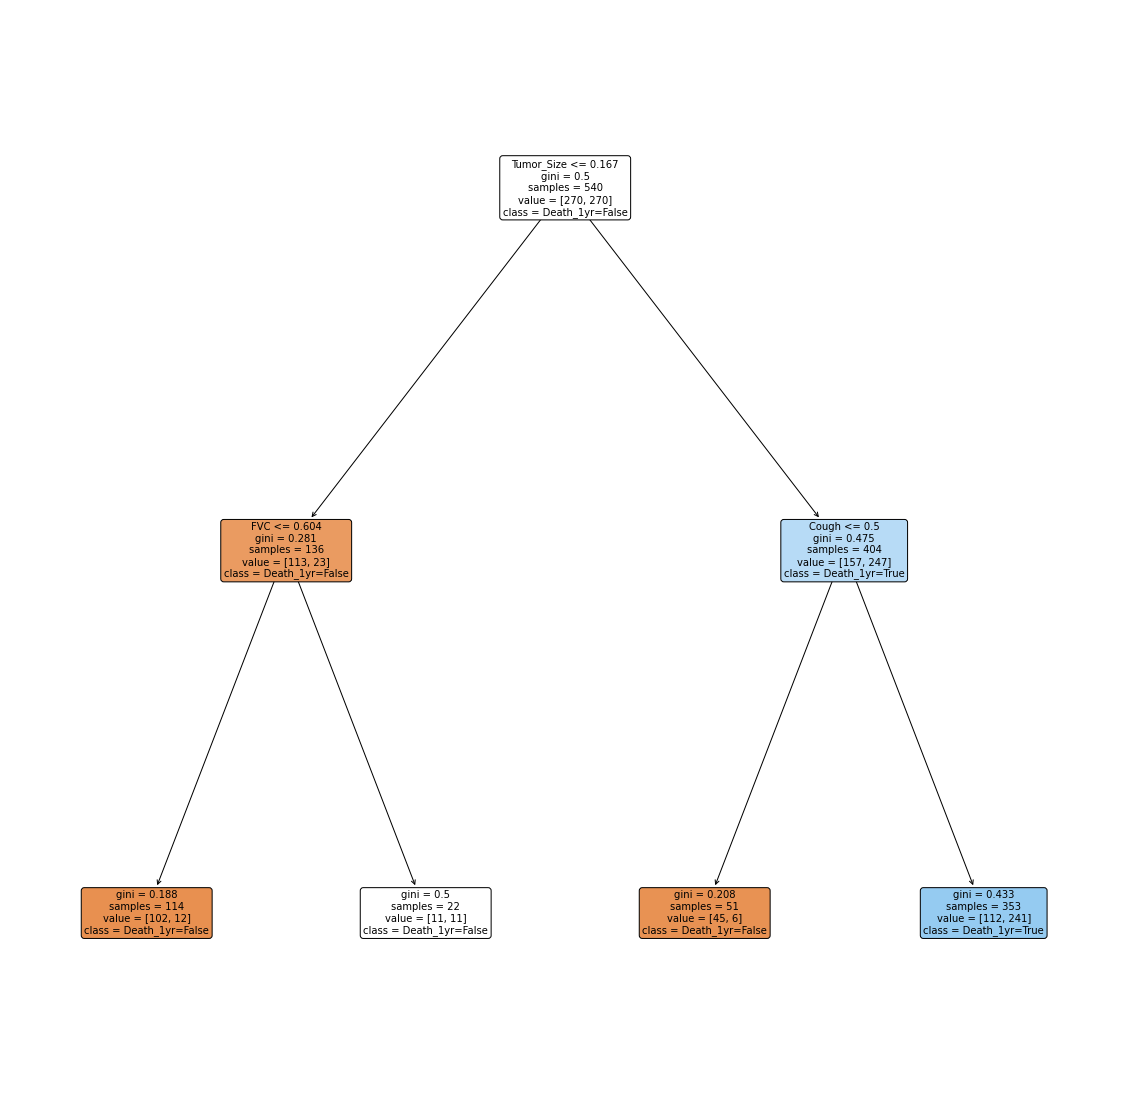

In [76]:
clf = tuned_classifiers['DecisionTree'][8]
X = load_dataset(name='ThoracicSurgery_test.csv')
plt.figure(figsize=(20,20))
tree.plot_tree(clf, fontsize=10, feature_names=X.columns, class_names=['Death_1yr=False', 'Death_1yr=True'], label='all', filled=True, rounded=True)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


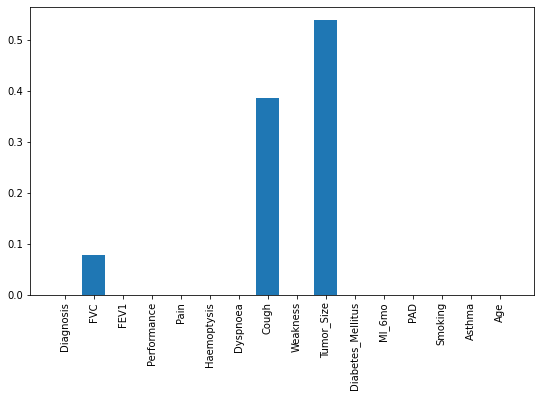

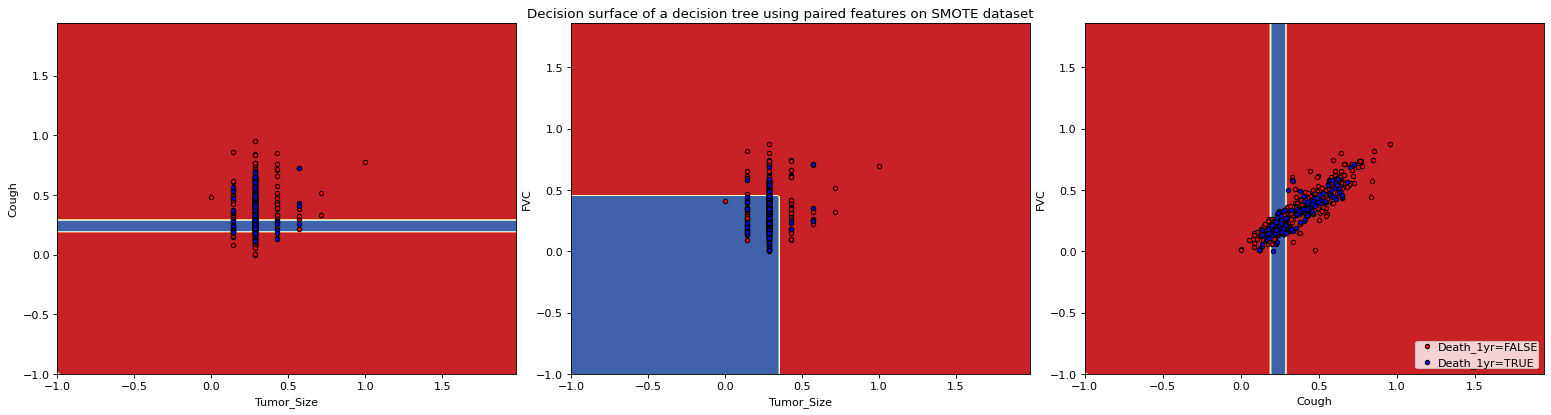

In [77]:
# Plot decision tree for SMOTE
df_train = train_datasets['SMOTE']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['DecisionTree'][8]
params = tuned_clf.get_params()
print(params)
clf = tree.DecisionTreeClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'decision tree', 'SMOTE')

### PCA

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


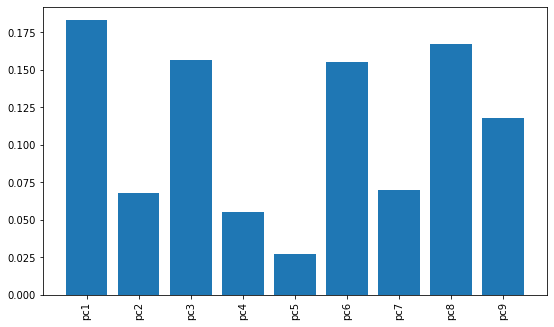

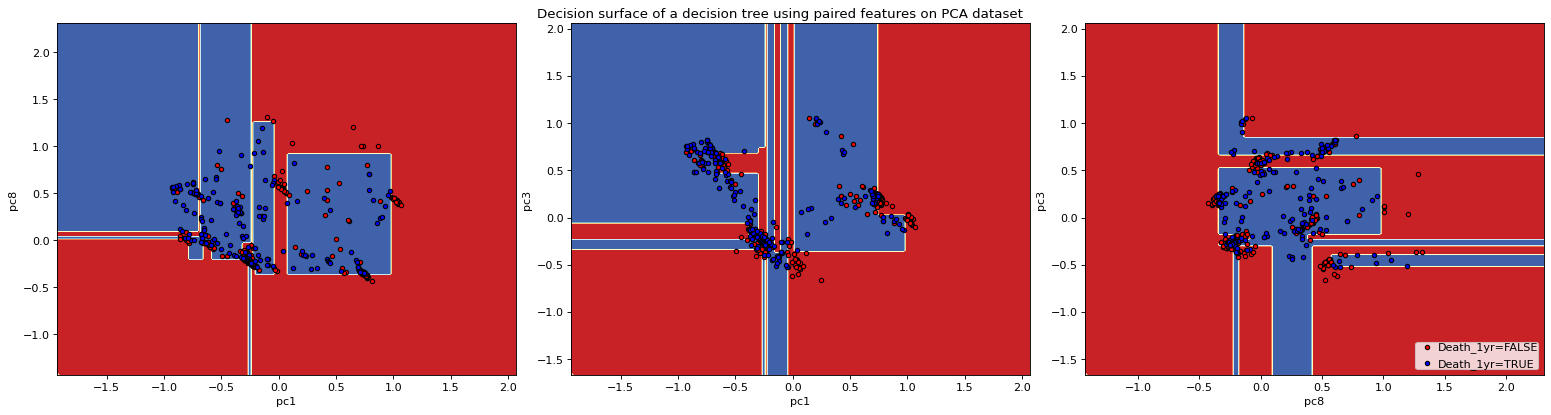

In [78]:
df_train = train_datasets['PCA']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['DecisionTree'][9]
params = tuned_clf.get_params()
print(params)
clf = tree.DecisionTreeClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'decision tree', 'PCA')

[Text(558.0, 951.3000000000001, 'pc8 <= 0.046\ngini = 0.5\nsamples = 540\nvalue = [270, 270]\nclass = Death_1yr=False'),
 Text(279.0, 679.5, 'pc1 <= 0.728\ngini = 0.475\nsamples = 360\nvalue = [140, 220]\nclass = Death_1yr=True'),
 Text(139.5, 407.70000000000005, 'pc4 <= -0.278\ngini = 0.45\nsamples = 319\nvalue = [109, 210]\nclass = Death_1yr=True'),
 Text(69.75, 135.89999999999998, '\n  (...)  \n'),
 Text(209.25, 135.89999999999998, '\n  (...)  \n'),
 Text(418.5, 407.70000000000005, 'pc9 <= 0.295\ngini = 0.369\nsamples = 41\nvalue = [31, 10]\nclass = Death_1yr=False'),
 Text(348.75, 135.89999999999998, '\n  (...)  \n'),
 Text(488.25, 135.89999999999998, '\n  (...)  \n'),
 Text(837.0, 679.5, 'pc3 <= 0.747\ngini = 0.401\nsamples = 180\nvalue = [130, 50]\nclass = Death_1yr=False'),
 Text(697.5, 407.70000000000005, 'pc6 <= 0.446\ngini = 0.332\nsamples = 162\nvalue = [128, 34]\nclass = Death_1yr=False'),
 Text(627.75, 135.89999999999998, '\n  (...)  \n'),
 Text(767.25, 135.89999999999998,

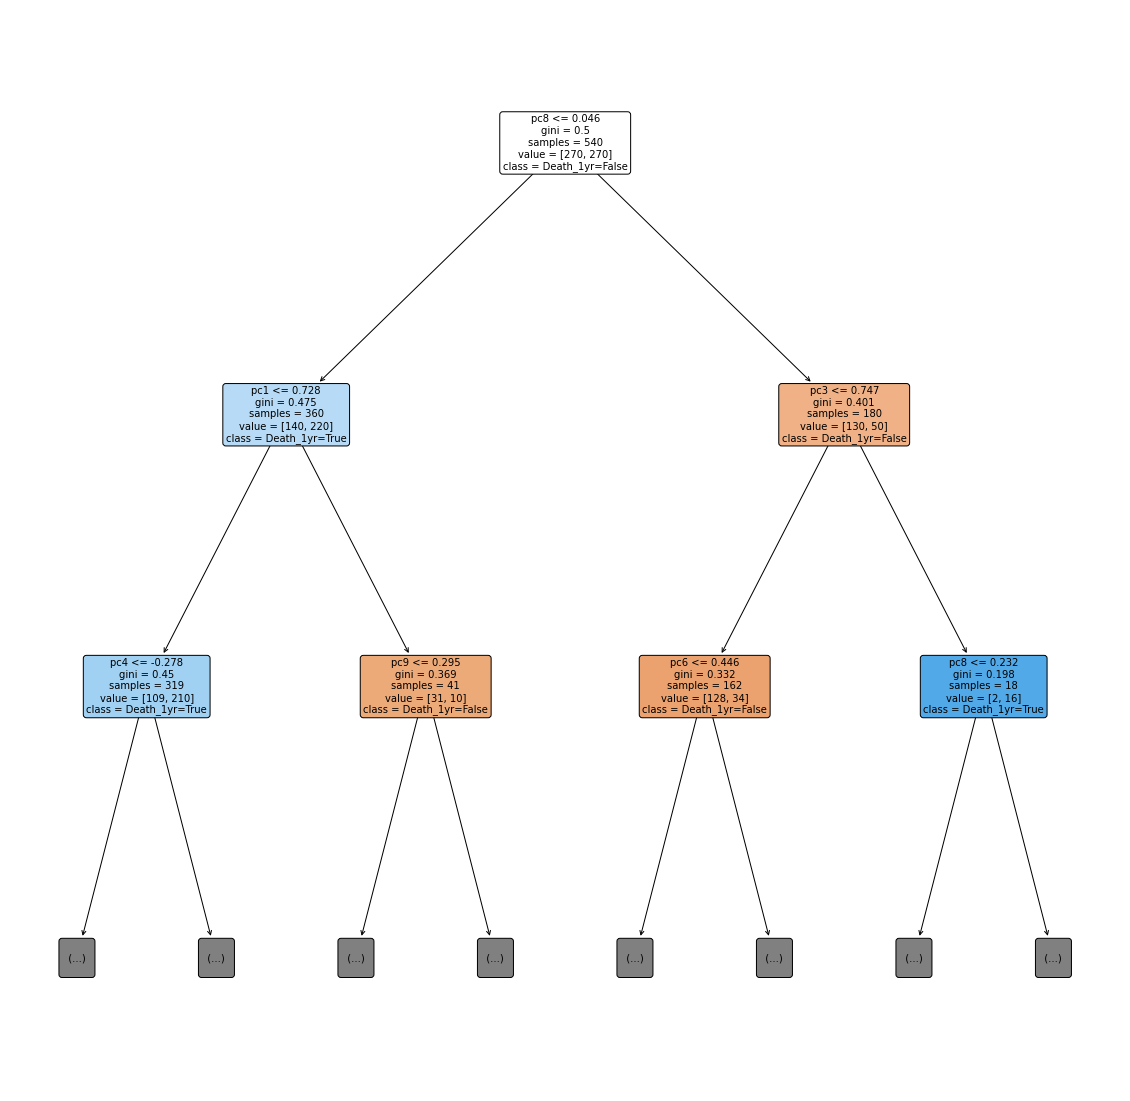

In [79]:
clf = tuned_classifiers['DecisionTree'][4]
X = train_datasets['PCA']
plt.figure(figsize=(20,20))
tree.plot_tree(clf, fontsize=10, feature_names=X.columns, class_names=['Death_1yr=False', 'Death_1yr=True'], label='all', filled=True, rounded=True, max_depth=2)

[Text(648.8203125, 1026.8, 'pc8 <= 0.046\ngini = 0.5\nsamples = 540\nvalue = [270, 270]\nclass = Death_1yr=False'),
 Text(335.671875, 906.0, 'pc1 <= 0.728\ngini = 0.475\nsamples = 360\nvalue = [140, 220]\nclass = Death_1yr=True'),
 Text(159.84375, 785.2, 'pc4 <= -0.278\ngini = 0.45\nsamples = 319\nvalue = [109, 210]\nclass = Death_1yr=True'),
 Text(46.5, 664.4, 'pc6 <= -0.033\ngini = 0.49\nsamples = 49\nvalue = [28, 21]\nclass = Death_1yr=False'),
 Text(23.25, 543.6, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]\nclass = Death_1yr=False'),
 Text(69.75, 543.6, 'pc2 <= -0.031\ngini = 0.486\nsamples = 36\nvalue = [15, 21]\nclass = Death_1yr=True'),
 Text(46.5, 422.79999999999995, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = Death_1yr=False'),
 Text(93.0, 422.79999999999995, 'pc1 <= -0.023\ngini = 0.375\nsamples = 28\nvalue = [7, 21]\nclass = Death_1yr=True'),
 Text(69.75, 302.0, 'pc5 <= 0.836\ngini = 0.219\nsamples = 24\nvalue = [3, 21]\nclass = Death_1yr=True'),
 Text(46.5, 181.1999999

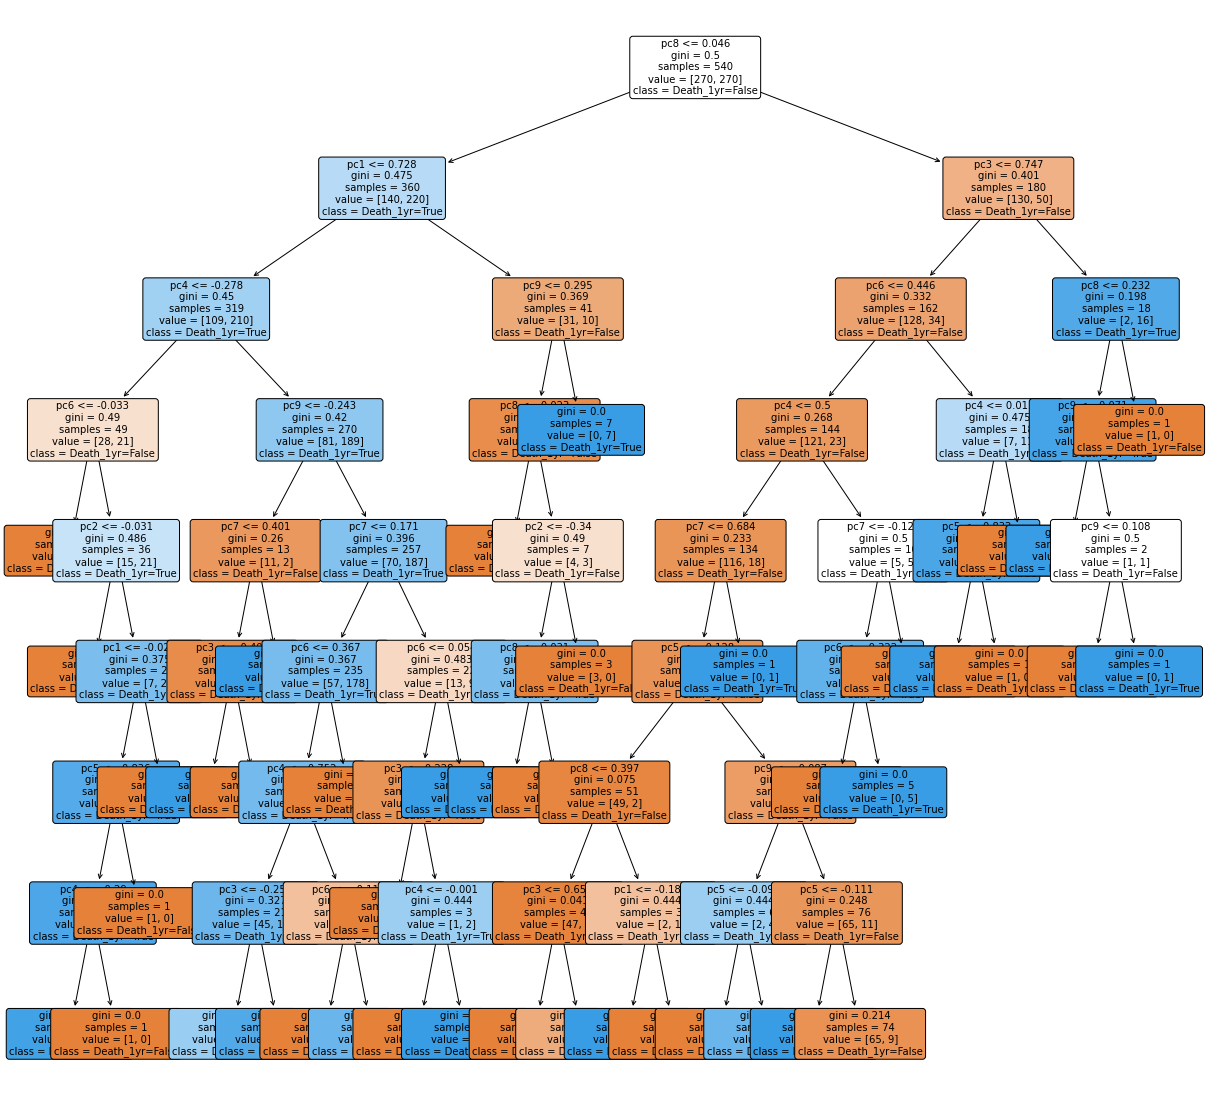

In [80]:
clf = tuned_classifiers['DecisionTree'][4]
X = train_datasets['PCA']
plt.figure(figsize=(20,20))
tree.plot_tree(clf, fontsize=10, feature_names=X.columns, class_names=['Death_1yr=False', 'Death_1yr=True'], label='all', filled=True, rounded=True)

## KNN

In [81]:
#print all params of the tuned KNN models
for classifier in tuned_classifiers['KNN']:
  print (classifier.get_params())

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 1, 'p':

In [82]:
print("RECALL TABLE")
recall_table.loc[["KNN"], :].head()

RECALL TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
KNN,0.142857,0.142857,0.428571,0.47619,0.380952


In [83]:
print("ACCURACY TABLE")
accuracy_table.loc[["KNN"], :].head()

ACCURACY TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
KNN,0.851064,0.846715,0.781022,0.642336,0.744526


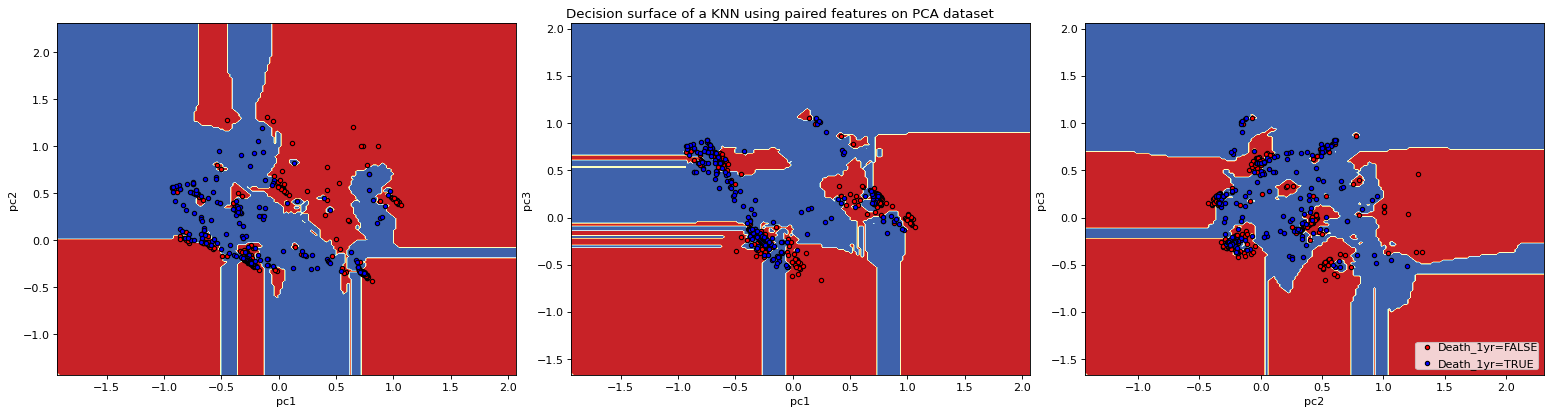

In [84]:
#plot decision boundary for PCA dataset
df_train = train_datasets['PCA']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['KNN'][9]
params = tuned_clf.get_params()

clf = neighbors.KNeighborsClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'KNN', 'PCA')

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}


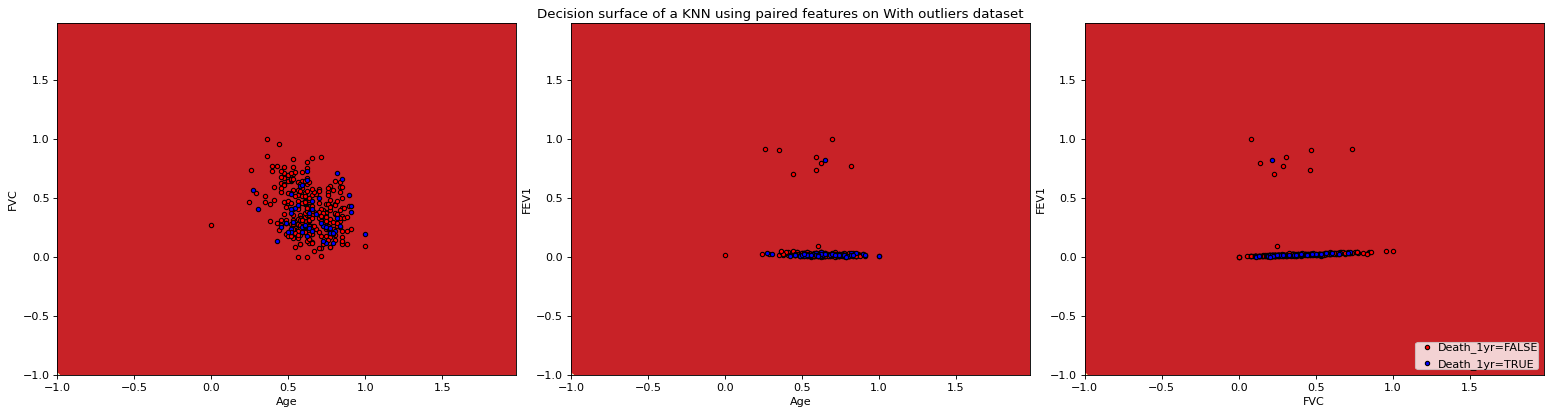

In [85]:
#plot decision boundary for  dataset whith outliers
df_train = train_datasets['with_outliers']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['KNN'][0]
params = tuned_clf.get_params()
print(params)

clf = neighbors.KNeighborsClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'KNN', 'With outliers', feature_pairs=[[16,2], [16,3], [2,3]])

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


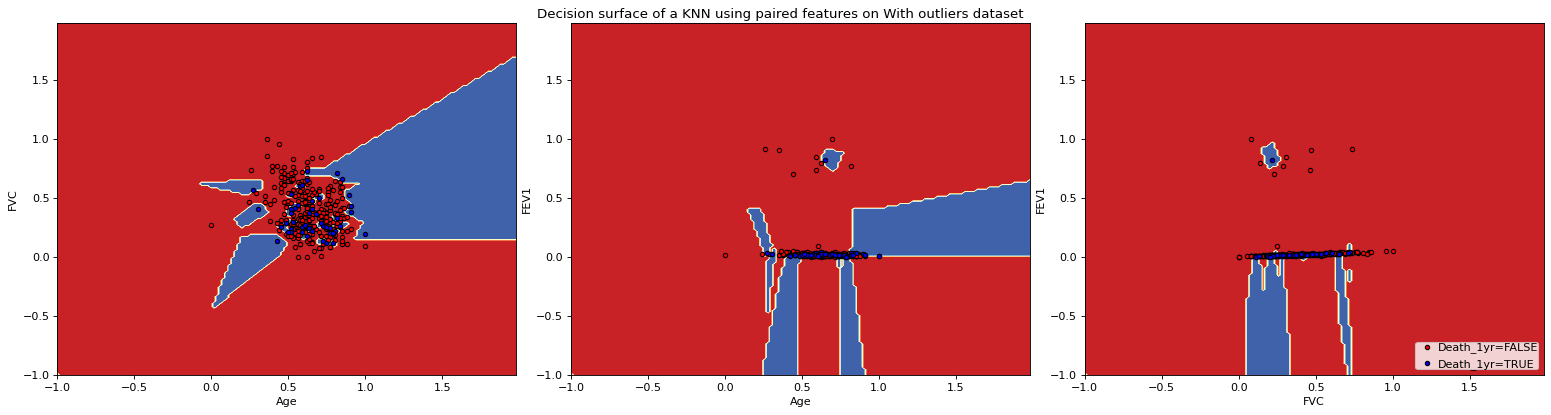

In [86]:
#plot decision boundary for  dataset whith outliers
df_train = train_datasets['with_outliers']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['KNN'][5]
params = tuned_clf.get_params()
print(params)

clf = neighbors.KNeighborsClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'KNN', 'With outliers', feature_pairs=[[16,2], [16,3], [2,3]])

In [87]:
knn_accuracy_tuned_clf = tuned_classifiers['KNN'][0]
knn_recall_tuned_clf = tuned_classifiers['KNN'][5]

df_train = train_datasets['with_outliers']
df_test = test_datasets['with_outliers']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

X_test = df_test[x_labels]
Y_test = df_test[y_label]

train_prediction_accuracy = knn_accuracy_tuned_clf.predict(X)
test_prediction_accuracy = knn_accuracy_tuned_clf.predict(X_test)

train_accuracy = confusion_matrix(Y, train_prediction_accuracy).ravel()
test_accuracy = confusion_matrix(Y_test, test_prediction_accuracy).ravel()

train_accuracy = (train_accuracy[0] + train_accuracy[3])/np.sum(train_accuracy)
test_accuracy = (test_accuracy[0] + test_accuracy[3])/np.sum(test_accuracy)

print("Train accuracy (model selected by accuracy): ", train_accuracy)
print("Test accuracy (model selected by accuracy): ", test_accuracy)

train_prediction_accuracy = knn_recall_tuned_clf.predict(X)
test_prediction_accuracy = knn_recall_tuned_clf.predict(X_test)

train_accuracy = confusion_matrix(Y, train_prediction_accuracy).ravel()
test_accuracy = confusion_matrix(Y_test, test_prediction_accuracy).ravel()

train_accuracy_ = (train_accuracy[0] + train_accuracy[3])/np.sum(train_accuracy)
test_accuracy_ = (test_accuracy[0] + test_accuracy[3])/np.sum(test_accuracy)
train_recall_ = train_accuracy[0]/(train_accuracy[0] + train_accuracy[2])
test_recall_ = test_accuracy[0]/(test_accuracy[0] + test_accuracy[2])

print("Train accuracy (model selected by recall): ", train_accuracy_)
print("Test accuracy (model selected by recall): ", test_accuracy_)
print("Train recall (model selected by recall): ", train_recall_)
print("Test recall (model selected by recall): ", test_recall_)

Train accuracy (model selected by accuracy):  0.851063829787234
Test accuracy (model selected by accuracy):  0.851063829787234
Train accuracy (model selected by recall):  1.0
Test accuracy (model selected by recall):  0.7801418439716312
Train recall (model selected by recall):  1.0
Test recall (model selected by recall):  0.856


In [88]:
!pip install mlxtend==0.19.0

     |████████████████████████████████| 1.3 MB 4.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [89]:
from mlxtend import evaluate
mse, bias, var = evaluate.bias_variance_decomp(
    knn_accuracy_tuned_clf, 
    X.values, 
    Y.values, 
    X_test.values, 
    Y_test.values, 
    loss='mse', 
    num_rounds=200, 
    random_seed=42)

print("Model selected by accuracy: ")
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

mse, bias, var = evaluate.bias_variance_decomp(
    knn_recall_tuned_clf, 
    X.values, 
    Y.values, 
    X_test.values, 
    Y_test.values, 
    loss='mse', 
    num_rounds=200, 
    random_seed=42)

print("Model selected by recall: ")
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

Model selected by accuracy: 
MSE: 0.153
Bias: 0.147
Variance: 0.006
Model selected by recall: 
MSE: 0.232
Bias: 0.169
Variance: 0.063


## Random Forest

In [90]:
#print all params of the tuned Random Forest models
for classifier in tuned_classifiers['RandomForest']:
  print (classifier.get_params())


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_s

In [91]:
print("RECALL TABLE")
recall_table.loc[["RandomForest"], :].head()

RECALL TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
RandomForest,0.0,0.0,0.285714,0.238095,0.380952


In [92]:
print("ACCURACY TABLE")
accuracy_table.loc[["RandomForest"], :].head()

ACCURACY TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
RandomForest,0.851064,0.846715,0.781022,0.664234,0.693431


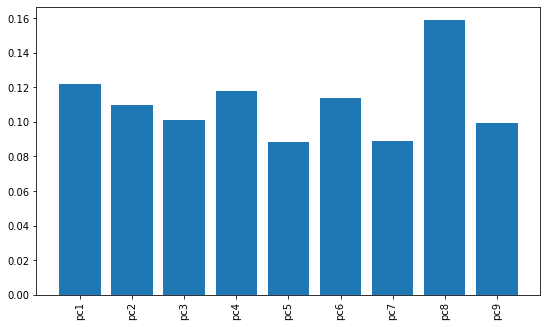

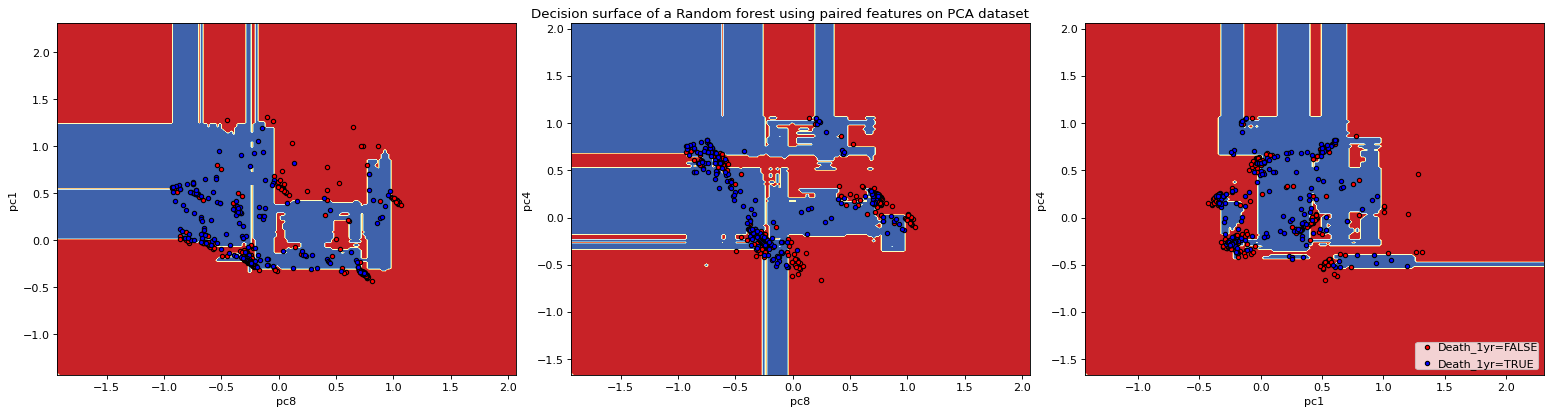

In [93]:
#plot features important and decision boundary for PCA dataset
df_train = train_datasets['PCA']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['RandomForest'][9]
params = tuned_clf.get_params()

clf = ensemble.RandomForestClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'Random forest', 'PCA')

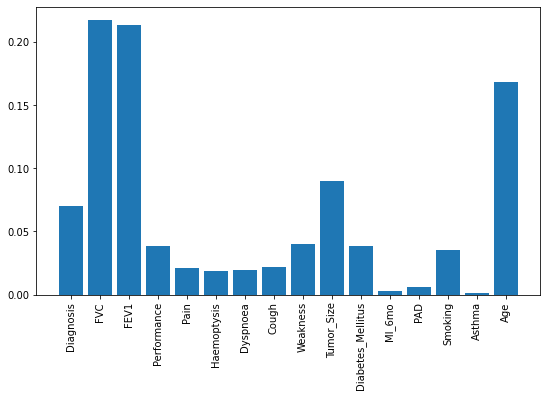

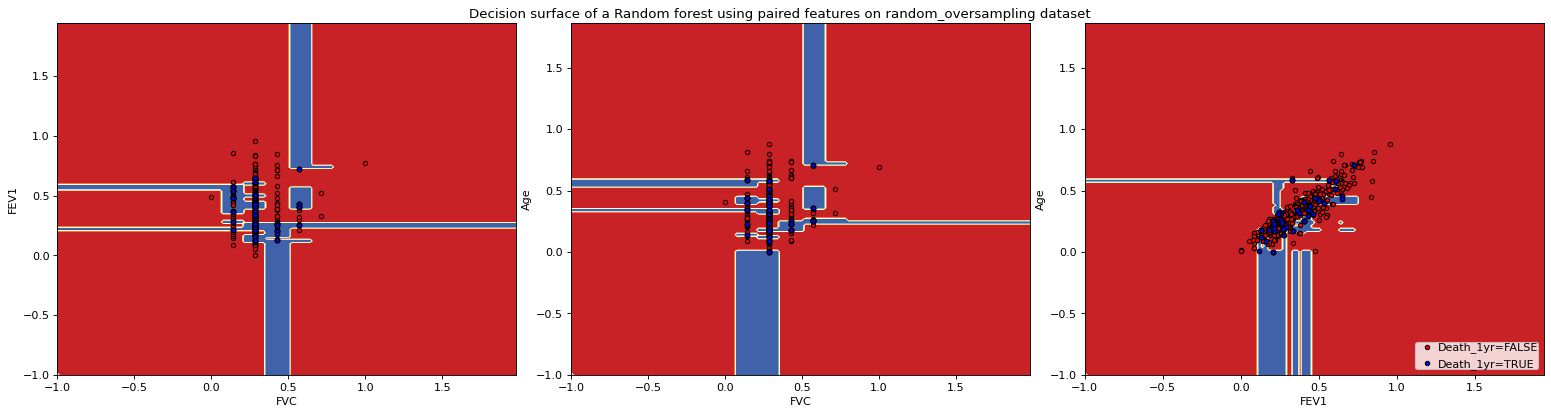

In [94]:
#plot features important and decision boundary for random:oversampling dataset
df_train = train_datasets['random_oversampling']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]

tuned_clf = tuned_classifiers['RandomForest'][7]
params = tuned_clf.get_params()

clf = ensemble.RandomForestClassifier(**params)

plot_decision_boundaries(X, Y, clf, 'Random forest', 'random_oversampling')

## SVC

In [95]:
print("RECALL TABLE")
recall_table.loc[["SVC"], :].head()

RECALL TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
SVC,0.0,0.047619,0.238095,0.809524,0.285714


In [96]:
print("ACCURACY TABLE")
accuracy_table.loc[["SVC"], :].head()

ACCURACY TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
SVC,0.851064,0.846715,0.729927,0.656934,0.70073


In [97]:
tuned_classifiers['SVC']

[SVC(C=0.1, gamma=1),
 SVC(C=0.1, gamma=1),
 SVC(C=100, gamma=1),
 SVC(C=100, gamma=1),
 SVC(C=100, gamma=1),
 SVC(C=100, gamma=0.001),
 SVC(C=100, gamma=0.1),
 SVC(C=100, gamma=1),
 SVC(C=0.1, gamma=0.001),
 SVC(C=100, gamma=1)]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


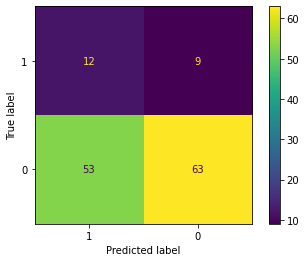

In [98]:
df_train = train_datasets['PCA']
df_test = test_datasets['PCA']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]


X_test = df_test[x_labels]
Y_test = df_test[y_label]

linear_svc = svm.SVC(kernel="poly", C=1, gamma=1)
linear_svc.fit(X, Y)
prediction = linear_svc.predict(X_test)

# plot_decision_boundaries(X, Y, linear_svc, 'linear-SVM', 'PCA')

plot_confusion_matrix(linear_svc, X_test, Y_test, labels=[1,0])

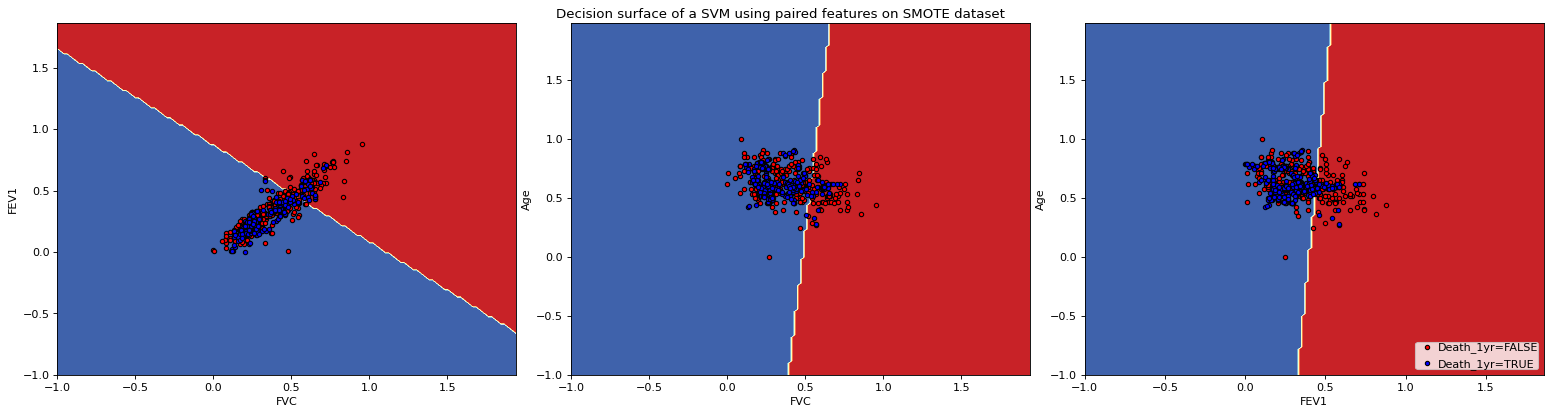

{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [99]:
clf = tuned_classifiers['SVC'][8]
df_train = train_datasets['SMOTE']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]
plot_decision_boundaries(X, Y, clf, 'SVM', 'SMOTE', [[1, 2], [1, 15], [2, 15]])
print(clf.get_params())

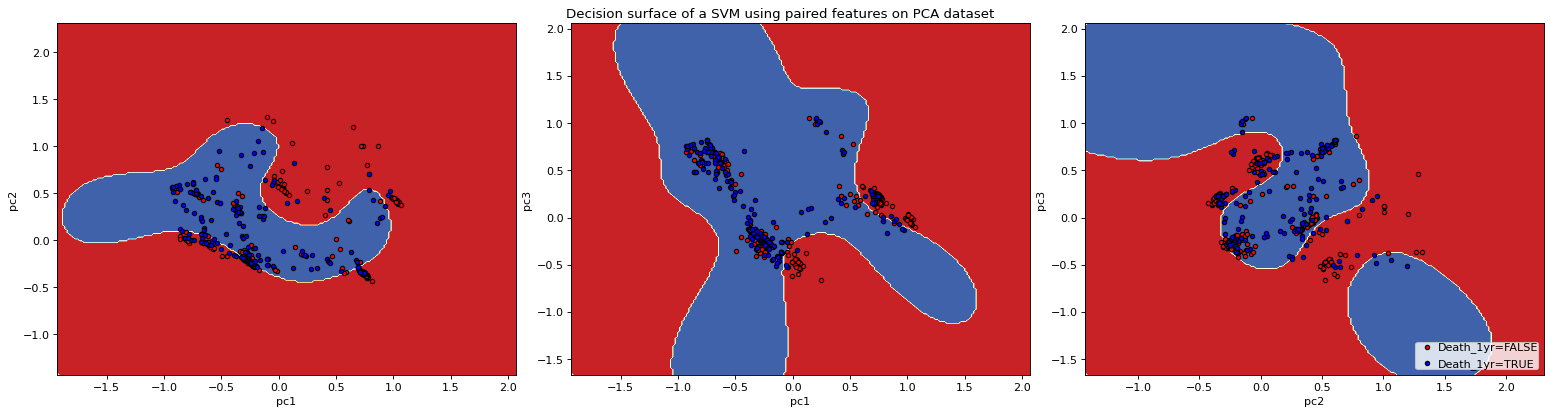

{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [100]:
clf = tuned_classifiers['SVC'][9]
df_train = train_datasets['PCA']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]
plot_decision_boundaries(X, Y, clf, 'SVM', 'PCA')
print(clf.get_params())

## Logistic regression

In [101]:
print("RECALL TABLE")
recall_table.loc[["LogisticRegression"], :].head()

RECALL TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
LogisticRegression,0.0,0.0,0.952381,0.952381,0.714286


In [102]:
print("ACCURACY TABLE")
accuracy_table.loc[["LogisticRegression"], :].head()

ACCURACY TABLE


,with_outliers,no_oversampling,random_oversampling,SMOTE,PCA
LogisticRegression,0.851064,0.846715,0.773723,0.562044,0.620438


In [103]:
tuned_classifiers['LogisticRegression'][2].get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [104]:
tuned_classifiers['LogisticRegression'][8].get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [105]:
coef = tuned_classifiers['LogisticRegression'][8].coef_[0]
len(coef)
for i, c in enumerate(coef):
  print(f"{c:.4f}", end=', ')

df_test = test_datasets['SMOTE']
index = 9

X = df_test[index:index+1].values[0][:16]
Y = df_test[index:index+1].values[0][-1]
print()
print(len(X))
print(len(coef))
print(Y)
sum = 0
for (x, beta) in zip(X, coef):
  sum = sum + x*beta

print()
print()
print("Sum is: ", sum)
import math
print(math.e ** sum / (1+math.e ** sum))
df_test[index:index+1].head()
# 3, 7, 13

-0.0022, -0.0079, -0.0094, 0.0101, -0.0046, -0.0073, -0.0031, 0.0314, -0.0086, 0.0116, -0.0072, -0.0010, -0.0025, 0.0179, -0.0010, -0.0024, 
16
16
1.0


Sum is:  0.057882554553083485
0.5144665998010379


,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,Death_1yr
9,0.166667,0.403292,0.40708,0.5,0,0,0,1,0,1.0,0,0,0,1,0,0.30303,1


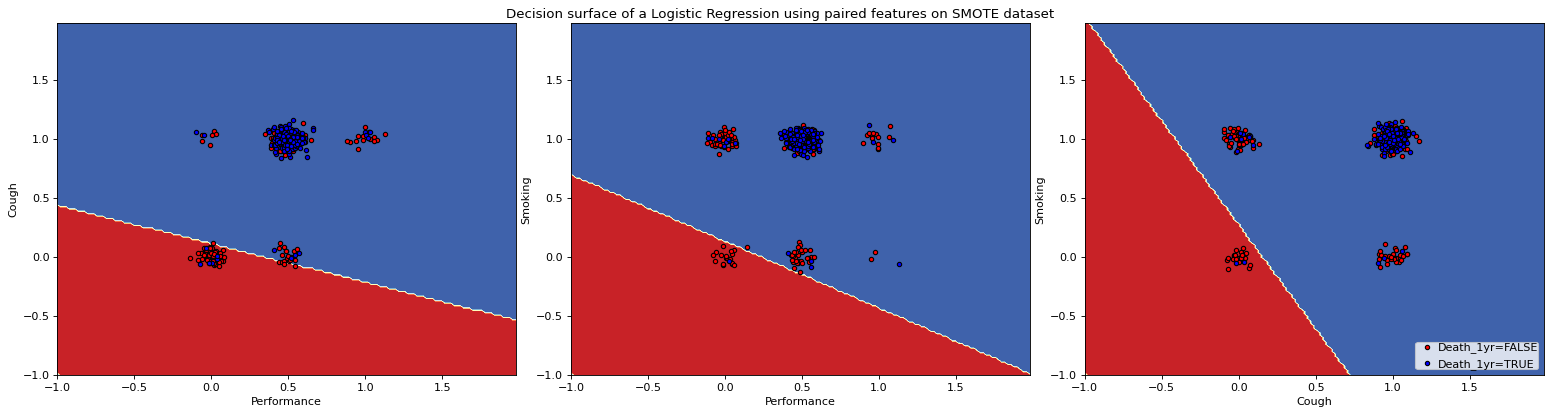

In [106]:
clf = tuned_classifiers['LogisticRegression'][8]
df_train = train_datasets['SMOTE']
x_labels = df_train.keys()[0:-1]
y_label = df_train.keys()[-1]

X = df_train[x_labels]
Y = df_train[y_label]
plot_decision_boundaries(X, Y, clf, 'Logistic Regression', 'SMOTE', [[3, 7], [3, 13], [7, 13]], noise=True)

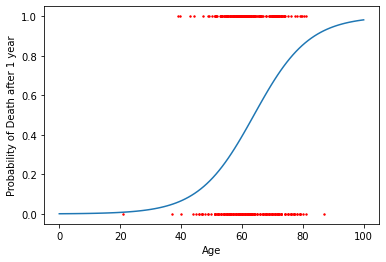

In [107]:
clf = tuned_classifiers['LogisticRegression'][7]
for feature in range(15,16):
  m = clf.coef_[0,feature]
  b = clf.intercept_[0]
  rescale_factor = 87-21
  #generate values for curve overlay
  lgs_curve = lambda x: 1/(1 + math.e**(100*(m*(x-rescale_factor)+b)))         
  x_values = np.linspace(0, 100, 100)
  y_values = lgs_curve(x_values)

  df_train = train_datasets['SMOTE']
  x_labels = df_train.keys()[0:-1]
  y_label = df_train.keys()[-1]

  X = df_train[x_labels[feature]]
  Y = df_train[y_label]

  #plot it
  x_v = X.values * (87-21) + 21
  plt.plot(x_values, y_values)
  plt.scatter(x_v, Y.values, c='r', s=2)
  plt.xlabel("Age")
  plt.ylabel("Probability of Death after 1 year")